## TC 3007B
### Word Embeddings

<br>

#### Activity 1: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (10%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    - Functionality (90%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (15% each for a total of 30%)
       - Similarity function (30%)
       - Analogy function (30%)
|



Team Members:

A01368818 Joel Sánchez Olvera

A01661090 Juan Pablo Cabrera Quiroga

A01704076 Adrián Galván Díaz

A01708634 Carlos Eduardo Velasco Elenes

A01709522 Arturo Cristián Díaz López

#### Import libraries

In [ ]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
plt.style.use('ggplot')

#### Load file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
%cd /content/drive/MyDrive/Colab Notebooks/Cantoral/
PATH = 'glove.6B.50d.txt'
! ls
emb_dim = 50

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Cantoral
embeddings_dict_50D.pkl			   TC3007B_NLP_HW1_embeddings.ipynb
glove.6B.50d.txt			   TC3007B_NLP_HW2_AD2024_text_classifier_updated-1.ipynb
TC3007B_NLP_embeddings_from_scratch.ipynb


In [ ]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
    """
    Create a dictionary of embeddings from a GloVe file.

    Args:
        path (str): Path to the GloVe file.

    Returns:
        dict: A dictionary where keys are words and values are embedding vectors.
    """
    emb_dict = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            emb_dict[word] = vector
    return emb_dict

In [ ]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

In [ ]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [ ]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [ ]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [ ]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func = PCA):
    """
    Visualize selected word embeddings using dimensionality reduction (PCA or t-SNE).

    Args:
        emb_path (str): Path to the embeddings file.
        words2show (list): List of words to visualize.
        emb_dim (int): Dimension of the embeddings.
        embeddings_dict (dict): Dictionary with word embeddings.
        func (function): Dimensionality reduction function (default is PCA).
    """
    selected_embeddings = []
    labels = []
    for word in words2show:
        if word in embeddings_dict:
            selected_embeddings.append(embeddings_dict[word])
            labels.append(word)
        else:
            print(f"Word '{word}' not found in embeddings dictionary.")

    # Convert to NumPy array
    selected_embeddings = np.array(selected_embeddings)

    # Apply dimensionality reduction
    reducer = func(n_components=2)
    reduced_embeddings = reducer.fit_transform(selected_embeddings)

    # Plot the reduced embeddings
    plt.figure(figsize=(20, 10))
    for i, label in enumerate(labels):
        x, y = reduced_embeddings[i, 0], reduced_embeddings[i, 1]
        plt.scatter(x, y, label=label)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')

    plt.title(f'Word Embeddings Visualized using {func.__name__}')
    plt.xlabel(f'{func.__name__} Dimension 1')
    plt.ylabel(f'{func.__name__} Dimension 2')
    plt.grid(True)
    plt.show()

In [ ]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


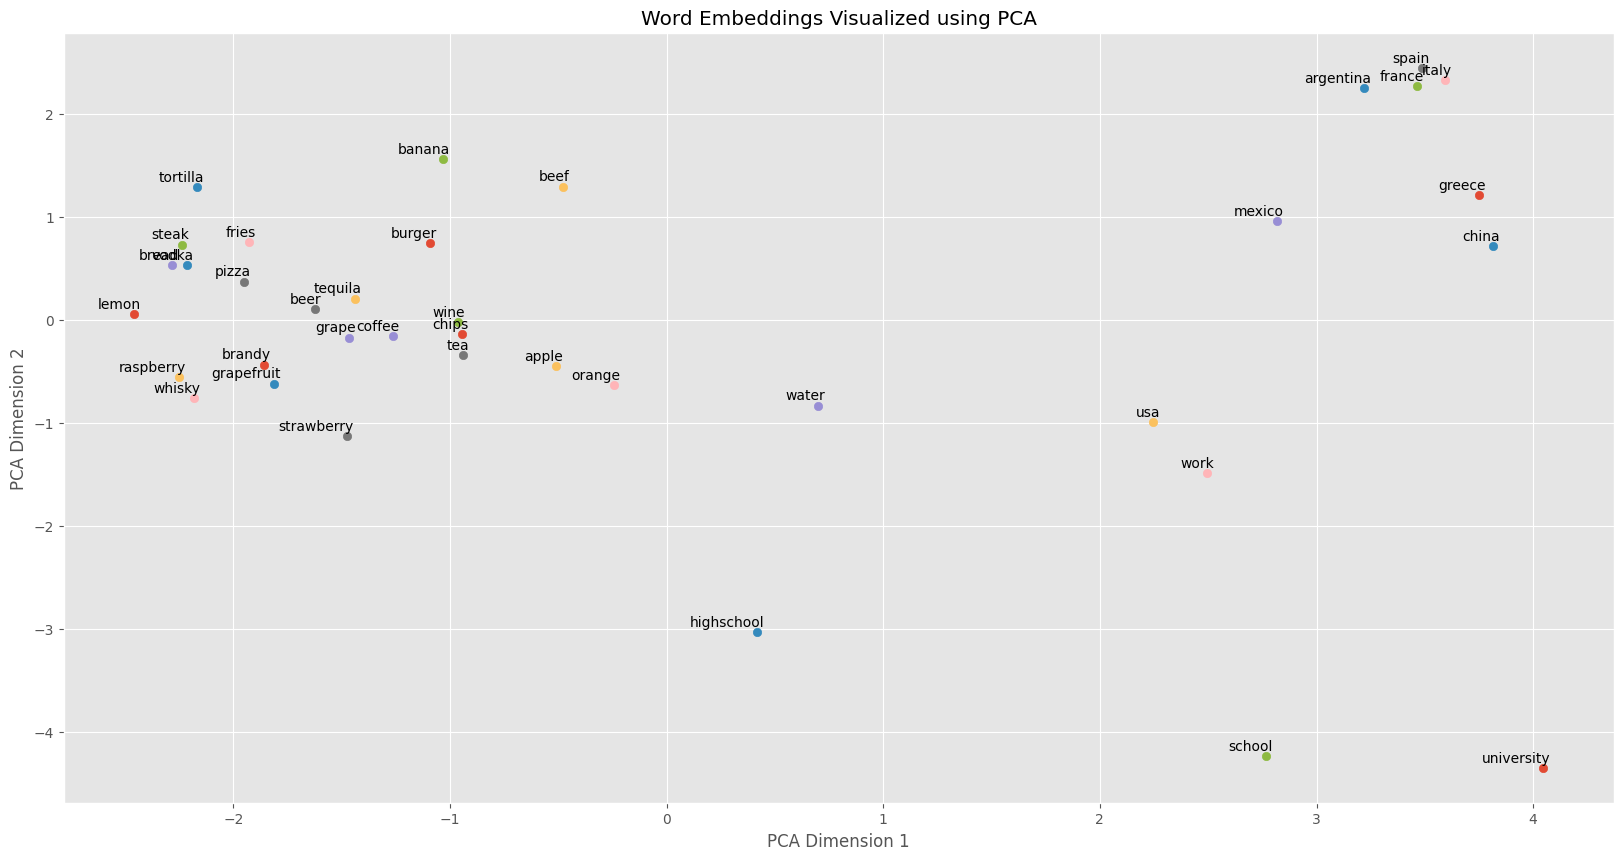

In [ ]:
#
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

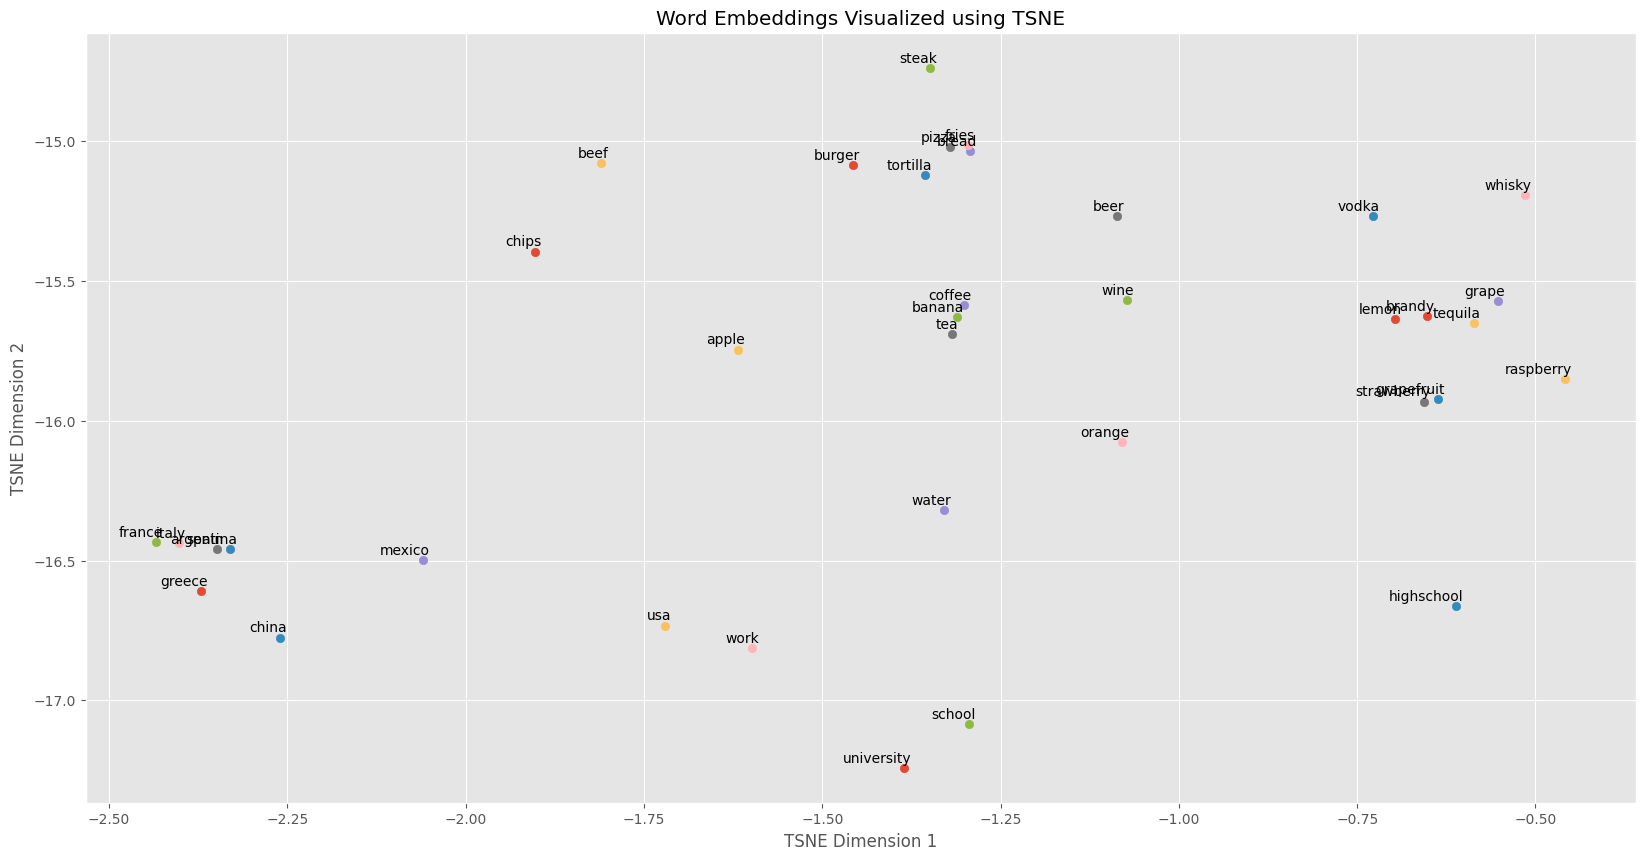

In [ ]:
from sklearn.manifold import TSNE
# t-SNE dimensionality reduction for visualization
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

In [ ]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
    """
    Solves the analogy: word1 is to word2 as word3 is to ?

    Args:
        word1 (str): First word in the analogy.
        word2 (str): Second word in the analogy.
        word3 (str): Third word in the analogy.
        embeddings_dict (dict): Dictionary with word embeddings.

    Returns:
        str: The word that best fits the analogy.
    """
    if word1 not in embeddings_dict or word2 not in embeddings_dict or word3 not in embeddings_dict:
        return "One or more words are not in the embeddings dictionary."

    # Compute analogy vector
    analogy_vector = embeddings_dict[word2] - embeddings_dict[word1] + embeddings_dict[word3]

    # Find the most similar word to the analogy vector
    best_word = None
    max_similarity = -float('inf')
    for word, vector in embeddings_dict.items():
        if word in [word1, word2, word3]:  # Exclude the input words
            continue
        similarity = np.dot(analogy_vector, vector) / (norm(analogy_vector) * norm(vector))
        if similarity > max_similarity:
            max_similarity = similarity
            best_word = word

    return best_word

In [ ]:
analogy('man', 'king', 'woman', embeddings_dict)

'queen'

In [ ]:
# most similar
def find_most_similar(word, embeddings_dict, top_n=10):
    """
    Finds the top_n most similar words to the given word.

    Args:
        word (str): The reference word.
        embeddings_dict (dict): Dictionary with word embeddings.
        top_n (int): Number of most similar words to return.

    Returns:
        list of tuples: List of (word, similarity) sorted by similarity.
    """
    if word not in embeddings_dict:
        return f"'{word}' is not in the embeddings dictionary."

    word_vector = embeddings_dict[word]
    similarities = {}

    # Compute cosine similarity with all other words
    for other_word, vector in embeddings_dict.items():
        if other_word == word:
            continue  # Skip the word itself
        similarity = np.dot(word_vector, vector) / (norm(word_vector) * norm(vector))
        similarities[other_word] = similarity

    # Sort by similarity and return top_n results
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similarities[:top_n]

In [ ]:
most_similar = find_most_similar('mexico', embeddings_dict)

In [ ]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> mexican
2 ---> venezuela
3 ---> colombia
4 ---> peru
5 ---> chile
6 ---> puerto
7 ---> rico
8 ---> cuba
9 ---> guatemala
10 ---> panama
